# 1 Introduction

## 1.1 Load and check data

In [1]:
# Import packages

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split
from statsmodels.graphics.mosaicplot import mosaic

In [2]:
# Set figsize for plots
plt.rcParams['figure.figsize'] = (8, 5)

# Set random state
random_state = 754

In [3]:
# Read data
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

# Concatenate training & test data
full = pd.concat([train, test], ignore_index=True)

# Check data
print(full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None


We've got a sense of our variables, their class type, and the first few observations of each. We know we're working with 1309 observations of 12 variables. To make things a bit more explicit since a couple of the variable names aren't 100% illuminating, here's what we've got to deal with:

Variable Name | Description
--------------|-------------
Survived      | Survived (1) or died (0)
Pclass        | Passenger's class
Name          | Passenger's name
Sex           | Passenger's sex
Age           | Passenger's age
SibSp         | Number of siblings/spouses aboard
Parch         | Number of parents/children aboard
Ticket        | Ticket number
Fare          | Fare
Cabin         | Cabin
Embarked      | Port of embarkation

# 2 Feature Engineering

## 2.1 What’s in a name?

In [4]:
# Grab title from passenger names
full['Title'] = full['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Show title counts by sex
pd.crosstab(full['Sex'], full['Title'])

Title,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0


In [5]:
# Titles with very low cell counts to be combined to "rare" level
rare_title = ['Dona', 'Lady', 'the Countess', 'Capt', 'Col', 'Don',
              'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

# Also reassign mlle, ms, and mme accordingly
full.loc[full['Title'] == 'Mlle', 'Title'] = 'Miss'
full.loc[full['Title'] == 'Ms', 'Title'] = 'Miss'
full.loc[full['Title'] == 'Mme', 'Title'] = 'Mrs'
full.loc[full['Title'].isin(rare_title), 'Title'] = 'Rare Title'

# Show title counts by sex again
pd.crosstab(full['Sex'], full['Title'])

Title,Master,Miss,Mr,Mrs,Rare Title
Sex,,,,,
female,0,264,0,198,4
male,61,0,757,0,25


In [6]:
# Finally, grab surname from passenger name
full['Surname'] = full['Name'].apply(lambda x: x.split(',')[0])

# Print the number of unique surnames
print(f'We have {full["Surname"].nunique()} unique surnames. I would be interested to infer ethnicity based on surname - another time.')

We have 875 unique surnames. I would be interested to infer ethnicity based on surname - another time.


## 2.2 Do families sink or swim together?

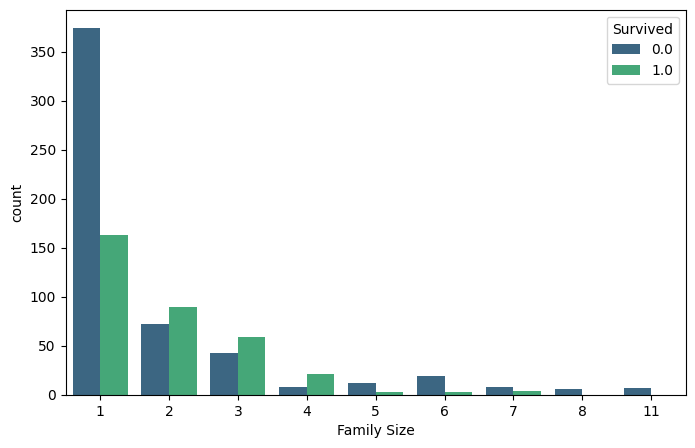

In [7]:
# Create a family size variable including the passenger themselves
full['Fsize'] = full['SibSp'] + full['Parch'] + 1

# Create a family variable
full['Family'] = full['Surname'] + '_' + full['Fsize'].astype(str)

# Use seaborn to visualize the relationship between family size & survival
sns.countplot(x='Fsize', hue='Survived', data=full.loc[:890], palette='viridis')
plt.xlabel('Family Size')
# plt.tight_layout()
plt.show()

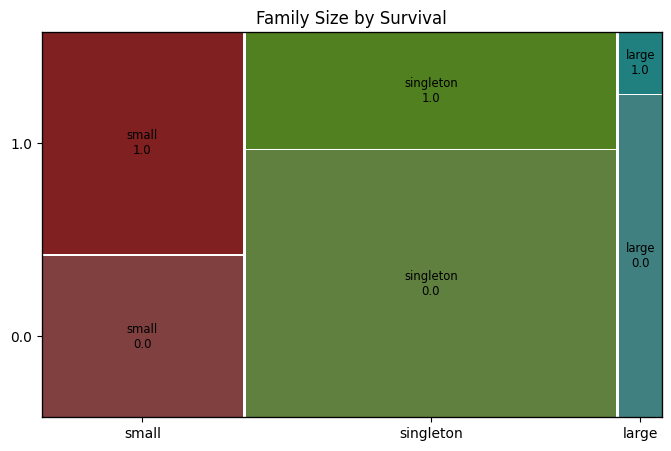

In [8]:
# Discretize family size
full.loc[full['Fsize'] == 1, 'FsizeD'] = 'singleton'
full.loc[(full['Fsize'] < 5) & (full['Fsize'] > 1), 'FsizeD'] = 'small'
full.loc[full['Fsize'] > 4, 'FsizeD'] = 'large'

# Show family size by survival using a mosaic plot
mosaic(full.loc[:890], ['FsizeD', 'Survived'], title='Family Size by Survival')
plt.show()

## 2.3 Treat a few more variables …

In [9]:
# This variable appears to have a lot of missing values
print(full['Cabin'][:28])

0             NaN
1             C85
2             NaN
3            C123
4             NaN
5             NaN
6             E46
7             NaN
8             NaN
9             NaN
10             G6
11           C103
12            NaN
13            NaN
14            NaN
15            NaN
16            NaN
17            NaN
18            NaN
19            NaN
20            NaN
21            D56
22            NaN
23             A6
24            NaN
25            NaN
26            NaN
27    C23 C25 C27
Name: Cabin, dtype: object


In [10]:
# The first character is the deck. For example:
print(list(full['Cabin'][1]))

['C', '8', '5']


In [11]:
# Create a Deck variable. Get passenger deck A - F:
full['Deck'] = full['Cabin'].apply(lambda x: list(x)[0] if pd.notna(x) else x)

# 3 Missingness

## 3.1 Sensible value imputation

In [12]:
# Passengers 62 and 830 are missing Embarkment
print(full.loc[[61, 829], 'Embarked'])

61     NaN
829    NaN
Name: Embarked, dtype: object


In [13]:
# Print the fare and class for passengers 62 and 830
fare1 = full.loc[61, 'Fare']
fare2 = full.loc[829, 'Fare']
class1 = full.loc[61, 'Pclass']
class2 = full.loc[829, 'Pclass']

print(f"We will infer their values for embarkment based on present data that we can imagine may be relevant: passenger class and fare. \
We see that they paid ${fare1} and ${fare2} respectively and their classes are {class1} and {class2}. \
So from where did they embark?")

We will infer their values for embarkment based on present data that we can imagine may be relevant: passenger class and fare. We see that they paid $80.0 and $80.0 respectively and their classes are 1 and 1. So from where did they embark?


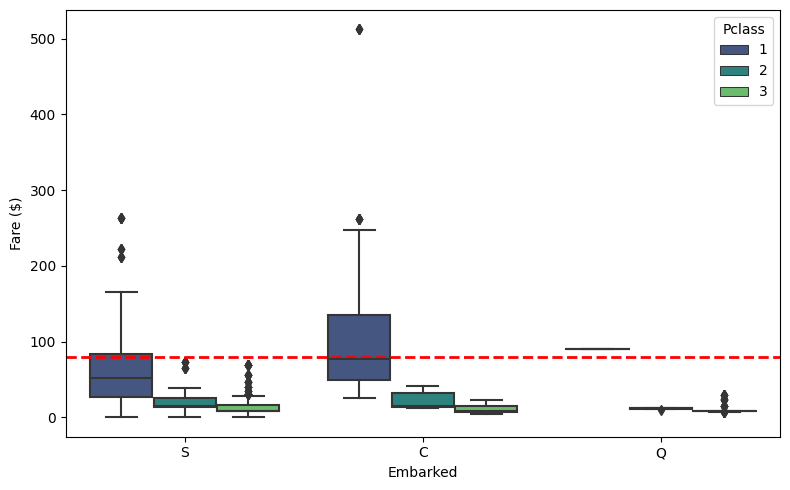

In [14]:
# Get rid of our missing passenger IDs
embark_fare = full.loc[(full['PassengerId'] != 62) & (full['PassengerId'] != 830)]

# Use seaborn to visualize embarkment, passenger class, & median fare
sns.boxplot(x='Embarked', y='Fare', hue='Pclass', data=embark_fare, palette='viridis')
plt.axhline(80, color='red', linestyle='dashed', linewidth=2)
plt.ylabel('Fare ($)')
plt.tight_layout()
plt.show()

In [15]:
# Since their fare was $80 for 1st class, they most likely embarked from 'C'
full.loc[[61, 829], 'Embarked'] = 'C'

# Show row 1044
print(full.loc[1043])  # Python uses 0-based indexing

PassengerId                  1044
Survived                      NaN
Pclass                          3
Name           Storey, Mr. Thomas
Sex                          male
Age                          60.5
SibSp                           0
Parch                           0
Ticket                       3701
Fare                          NaN
Cabin                         NaN
Embarked                        S
Title                          Mr
Surname                    Storey
Fsize                           1
Family                   Storey_1
FsizeD                  singleton
Deck                          NaN
Name: 1043, dtype: object


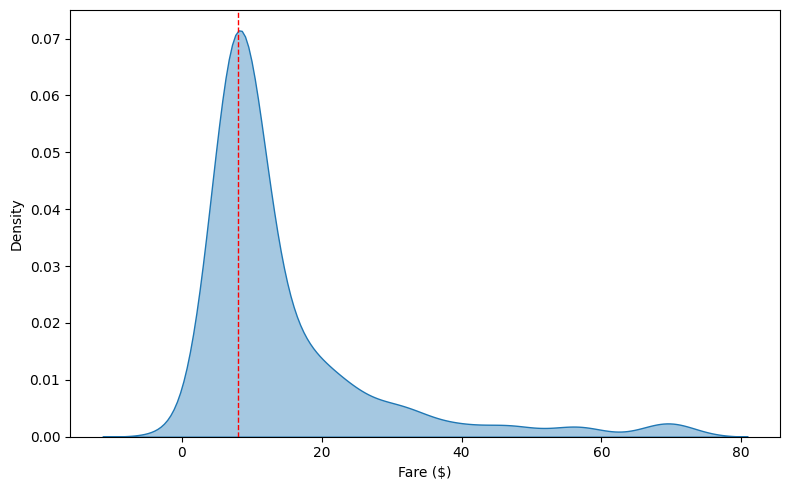

In [16]:
# Visualize the fare distribution for 3rd class passengers who embarked from 'S'
sns.kdeplot(data=full[(full['Pclass'] == 3) & (full['Embarked'] == 'S')]['Fare'], fill='#99d6ff', alpha=0.4)
plt.axvline(full[(full['Pclass'] == 3) & (full['Embarked'] == 'S')]['Fare'].median(), color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Fare ($)')
plt.tight_layout()
plt.show()

## 3.2 Predictive imputation

In [17]:
# Show number of missing Age values
print(full['Age'].isna().sum())

263


In [18]:
# Convert certain variables to 'category' type
category_vars = ['PassengerId','Pclass','Sex','Embarked','Title','Surname','Family','FsizeD']
for var in category_vars:
    full[var] = full[var].astype('category')

# One-hot encode the DataFrame
full_encoded = pd.get_dummies(full)

# Define the variables to exclude during imputation
vars_to_exclude = ['PassengerId','Name','Ticket','Cabin','Family','Surname','Survived']

# Perform SimpleImputation on the non-excluded variables
imputer = SimpleImputer(strategy='median')
full_no_excluded = full_encoded.loc[:, ~full_encoded.columns.isin(vars_to_exclude)]
mice_mod = imputer.fit_transform(full_no_excluded)

In [19]:
# # The second part is time consuming -> 40 mins on Macbook Pro M1/16/512
# # Perform iterative imputation on the non-excluded variables
# imputer = IterativeImputer(estimator=RandomForestRegressor(), missing_values=np.nan, random_state=random_state)
# full_no_excluded = full_encoded.loc[:, ~full_encoded.columns.isin(vars_to_exclude)]
# mice_mod = imputer.fit_transform(full_no_excluded)

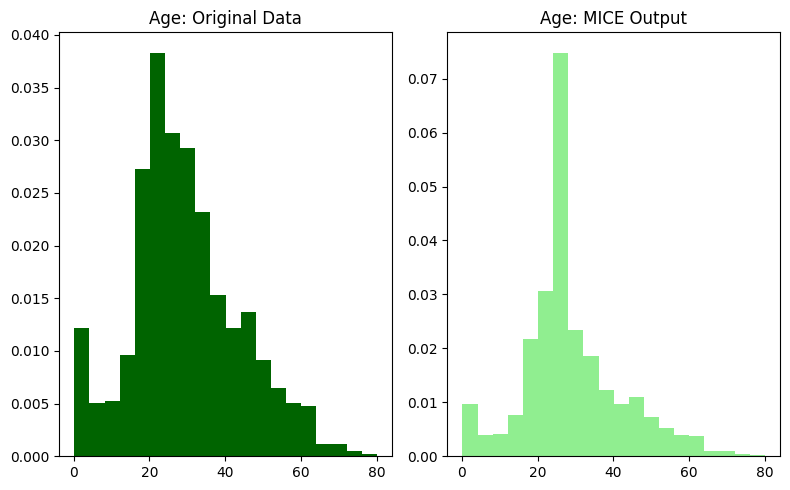

In [20]:
# Save the complete output
mice_output = pd.DataFrame(mice_mod, columns=full_no_excluded.columns)

# Plot age distributions
plt.subplot(1,2,1)
plt.hist(full['Age'], bins=20, color='darkgreen', density=True)
plt.title('Age: Original Data')

plt.subplot(1,2,2)
plt.hist(mice_output['Age'], bins=20, color='lightgreen', density=True)
plt.title('Age: MICE Output')

plt.tight_layout()
plt.show()

In [21]:
# Replace Age variable from the mice model.
full['Age'] = mice_output['Age']

# Show new number of missing Age values
print(full['Age'].isna().sum())

0


## 3.3 Feature Engineering: Round 2

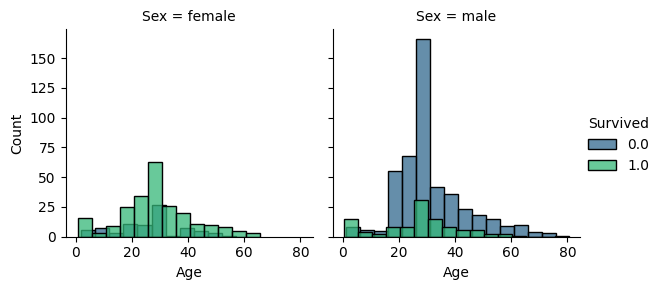

In [22]:
# Plot the relationship between age & survival
# Create FacetGrid
g = sns.FacetGrid(full[:891], col='Sex', hue='Survived', palette='viridis')

# Add histogram
_ = g.map_dataframe(sns.histplot, x='Age', multiple="stack", binwidth=5)

# Add a legend
_ = g.add_legend()


In [23]:
# Create the column child, and indicate whether child or adult
full.loc[full['Age'] < 18, 'Child'] = 'Child'
full.loc[full['Age'] >= 18, 'Child'] = 'Adult'

# Show counts
pd.crosstab(full['Child'], full['Survived'])

Survived,0.0,1.0
Child,,
Adult,497,281
Child,52,61


In [24]:
# Adding Mother variable
full.loc[(full['Sex'] == 'female') & (full['Parch'] > 0) & (full['Age'] > 18) & (full['Title'] != 'Miss'), 'Mother'] = 'Mother'
full['Mother'].fillna('Not Mother', inplace=True)

# Show counts
pd.crosstab(full['Mother'], full['Survived'])

Survived,0.0,1.0
Mother,,
Mother,16,39
Not Mother,533,303


In [25]:
# Convert new variables to category type
full['Child'] = full['Child'].astype('category')
full['Mother'] = full['Mother'].astype('category')

In [26]:
# One Hot Encoding

# Create a copy of the dataset
full_encoded = full.copy()

# List of columns to encode
columns_to_encode = ['Pclass', 'Sex', 'Embarked', 'Title', 'FsizeD', 'Child', 'Mother']

# Apply one-hot encoding to each column in columns_to_encode
encoded_columns = []
for column in columns_to_encode:
    encoded = pd.get_dummies(full_encoded[column], prefix=column)
    encoded_columns.extend(encoded.columns)
    full_encoded = pd.concat([full_encoded, encoded], axis=1)
    full_encoded.drop(columns=[column], inplace=True)

full_encoded = full_encoded[~full_encoded.Survived.isnull()]
# Print the list of all created columns
encoded_columns

['Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Rare Title',
 'FsizeD_large',
 'FsizeD_singleton',
 'FsizeD_small',
 'Child_Adult',
 'Child_Child',
 'Mother_Mother',
 'Mother_Not Mother']

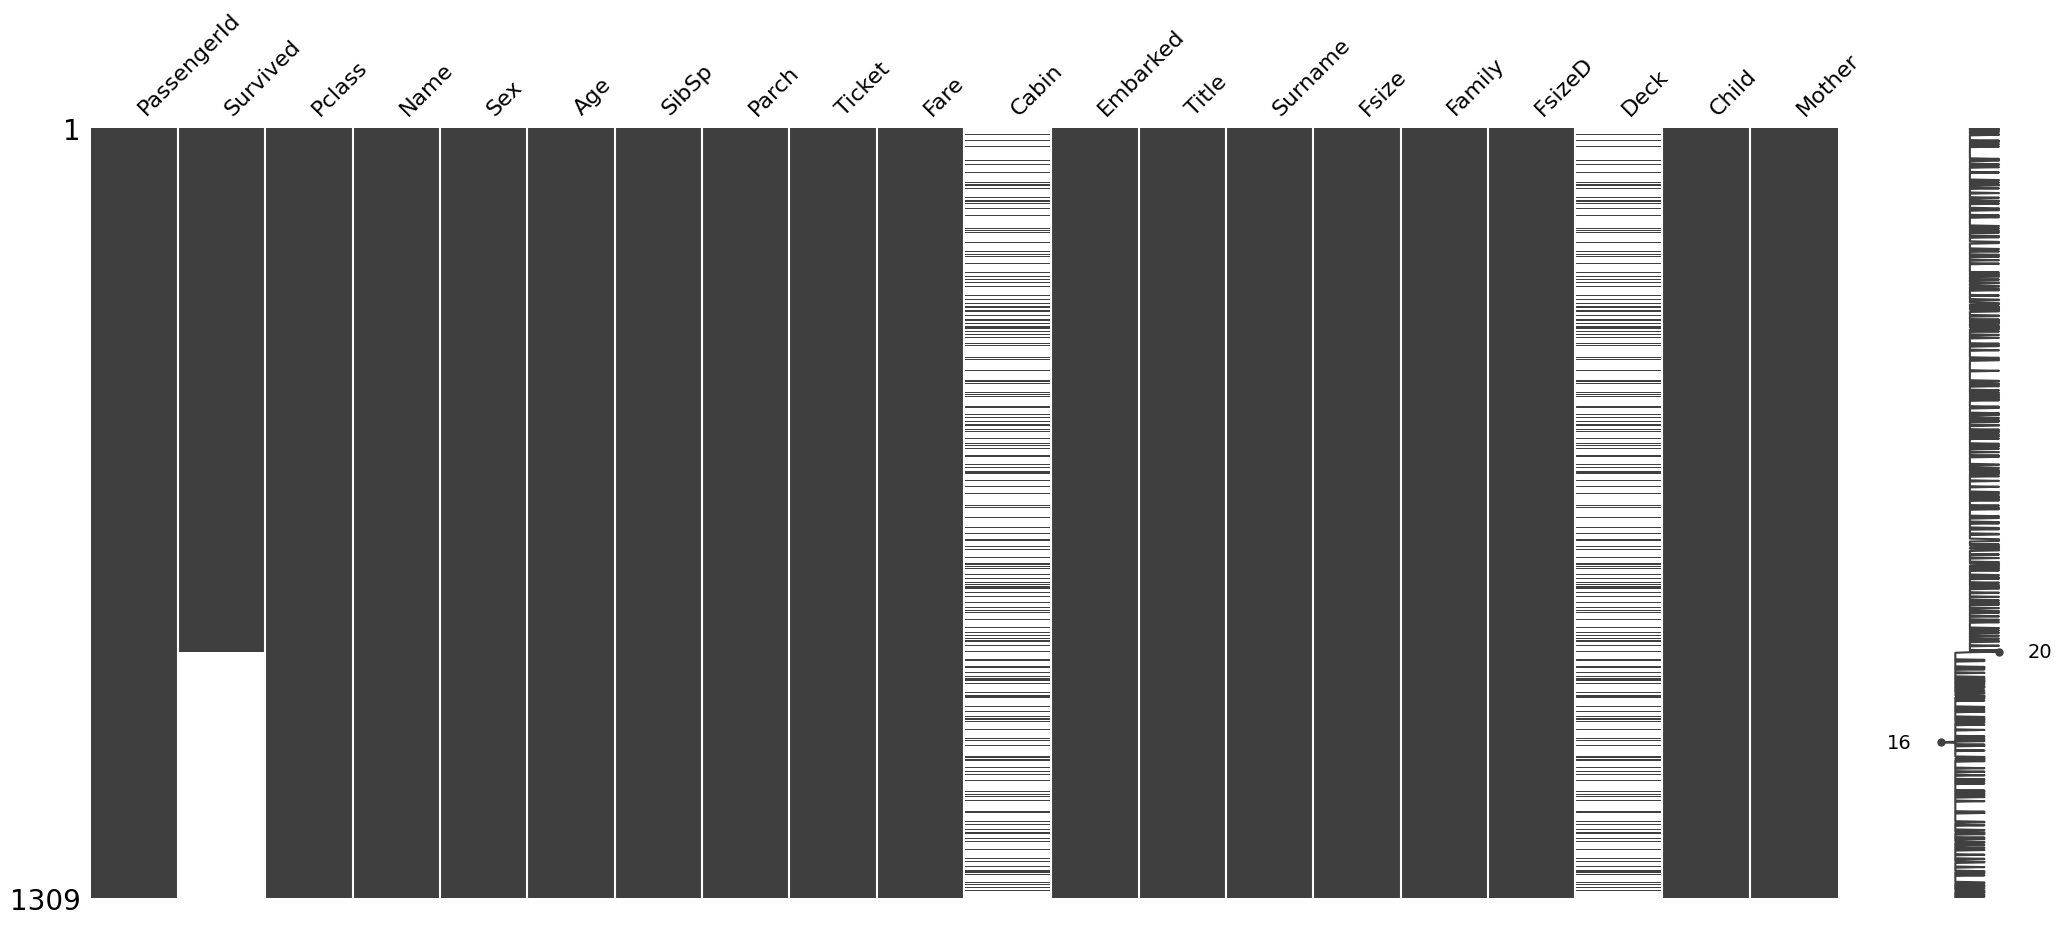

In [27]:
# Visualize missing data pattern
_ = msno.matrix(full)

#Probably to drop

# 4 Prediction

## 4.1 Split into training & test sets

In [28]:
train = full_encoded[:623]
test = full_encoded[623:]

## 4.2 Building the model

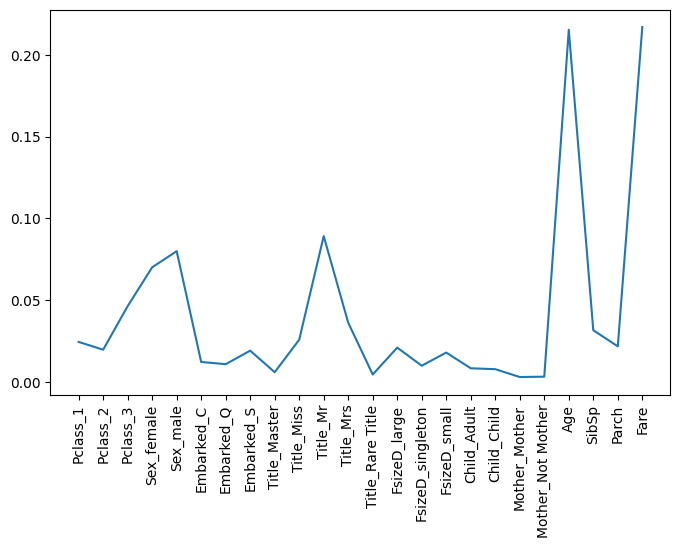

In [29]:
# Select predictors
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Title", "FsizeD", "Child", "Mother"]
predictors = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
              'Title_Rare Title', 'FsizeD_large', 'FsizeD_singleton', 'FsizeD_small', 'Child_Adult', 'Child_Child', 'Mother_Mother', 'Mother_Not Mother', 'Age', 'SibSp',
              'Parch', 'Fare']

# Converting categorical variables into numerical
for dataset in [train, test]:
    for column in predictors:
        if dataset[column].dtype == 'object':
            dataset[column] = dataset[column].astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(train[predictors], train["Survived"], random_state=random_state)

# Build the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=random_state)
rf_model.fit(X_train, y_train)

# Show model error
plt.plot(rf_model.feature_importances_)
plt.xticks(np.arange(train[predictors].shape[1]), predictors, rotation='vertical')
plt.show()

## 4.3 Variable importance

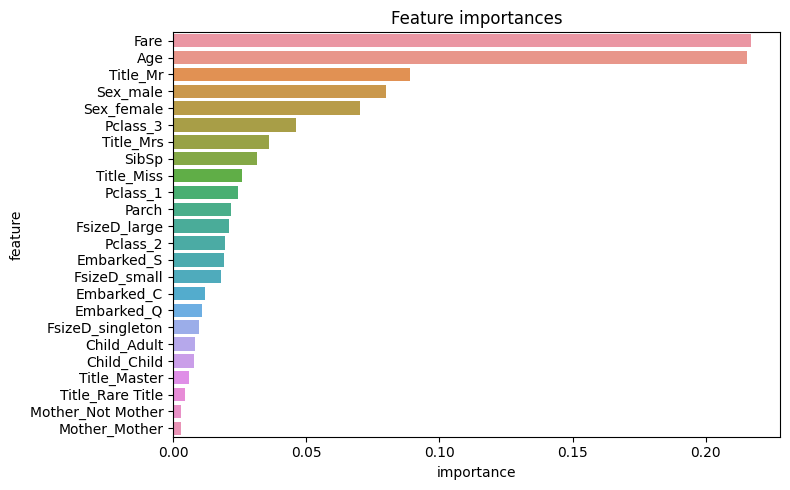

In [30]:
# Get importance
importance = pd.DataFrame({'feature': X_train.columns, 'importance': rf_model.feature_importances_})

# Order it based on the importance
importance = importance.sort_values('importance', ascending=False)

# Visualize the relative importance of variables
sns.barplot(x='importance', y='feature', data=importance)
plt.title('Feature importances')
plt.tight_layout()

## 4.4 Prediction!

In [31]:
# Predict using the test set
predictions = rf_model.predict(test[predictors])

# Save the solution to a dataframe with two columns: PassengerId and Survived (prediction)
solution = pd.DataFrame({"PassengerID": test["PassengerId"], "Survived": predictions})

# Write the solution to file
solution.to_csv('rf_mod_solution.csv', index=False)